In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline

leaspy_path = os.path.join("/Users/samuel.gruffaz/Documents/leaspy/", '..', '..')
print(leaspy_path)

print(sys.path)
os.chdir("/Users/samuel.gruffaz/Documents/leaspy")
sys.path.append("/Users/samuel.gruffaz/Documents/leaspy/leaspy")
from leaspy.api import Leaspy
#from lea AlgorithmSettings, IndividualParameters
from leaspy import AlgorithmSettings, IndividualParameters, Data

algo_settings = AlgorithmSettings('mcmc_saem', 
                                  n_iter=3000,           # n_iter defines the number of iterations
                                  loss="MSE_diag_noise", # To get a noise value per feature - keep it this way ;)
                                  progress_bar=True)     # To display a nice progression bar during calibration
algo_settings.set_logs(
    path='logs3',         # Creates a logs file ; if existing, ask if rewrite it
    plot_periodicity=50, # Saves the values to display in pdf every 50 iterations
    save_periodicity=10, # Saves the values in csv files every 10 iterations
    console_print_periodicity=100,# if = N, it display logs in the console/terminal every N iterations
    overwrite_logs_folder=True
)

/Users/samuel.gruffaz/Documents/leaspy/../..
['/Users/samuel.gruffaz/Documents/leaspy/example/start', '/Users/samuel.gruffaz/.vscode/extensions/ms-toolsai.jupyter-2021.3.684299474/pythonFiles', '/Users/samuel.gruffaz/.vscode/extensions/ms-toolsai.jupyter-2021.3.684299474/pythonFiles/lib/python', '/opt/anaconda3/envs/leaspy/lib/python37.zip', '/opt/anaconda3/envs/leaspy/lib/python3.7', '/opt/anaconda3/envs/leaspy/lib/python3.7/lib-dynload', '', '/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages', '/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/IPython/extensions', '/Users/samuel.gruffaz/.ipython']

...overwrite logs folder...


In [2]:
os.chdir("/Users/samuel.gruffaz/Documents/data/")
df=pd.read_csv("ADNI_img_clean.csv")


In [3]:
df = df.set_index(['ID', 'TIME'])
indices = [idx for idx in df.index.unique('ID') if df.loc[idx].shape[0] >= 2]
df = df[df.index.get_level_values(0).isin(indices)]

In [9]:
print(df.columns[5:15])

Index(['Frontal_Sup_2_L', 'Frontal_Sup_2_R', 'Frontal_Mid_2_L',
       'Frontal_Mid_2_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R',
       'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_2_L',
       'Frontal_Inf_Orb_2_R'],
      dtype='object')


In [15]:
print(df.columns[43:49])

Index(['Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L',
       'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R'],
      dtype='object')


In [17]:
print(df.columns[60:70])

Index(['Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L',
       'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L',
       'Parietal_Inf_R', 'SupraMarginal_L'],
      dtype='object')


In [4]:
#dg=(1-df[df.columns[43:49]])
dg=df[df.columns[3:6]]/0.7


# —— Store the data into a Data object
data1 = Data.from_dataframe(dg)

In [24]:
print(dg.head())

         Precentral_L  Precentral_R  Frontal_Sup_2_L
ID TIME                                             
4  67.5      0.399873      0.361596         0.494182
   68.0      0.379982      0.349022         0.501891
   68.5      0.395428      0.368886         0.484491
   69.0      0.376217      0.357283         0.495617
   70.5      0.373432      0.357430         0.475341


In [5]:
modelasymp=Leaspy("logistic_asymp")
modelasymp.model.load_hyperparameters({'source_dimension': 1}) 

In [6]:
os.chdir("/Users/samuel.gruffaz/Documents/leaspy")
modelasymp.fit(data1,algo_settings)

betas : tensor([[0.5542],
        [0.4592],
        [0.3588]])
tau_mean : 76.2472915649414
tau_std : 5.02709436416626
xi_mean : 0.0
xi_std : 1.7571368217468262
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.0322, 0.0275, 0.0471])

Duration since last print : 9.0476s
|#########-----------------------------------------|   540/3000 iterations
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 600
=Samplers 
    g rate : 33.33%, std: 0.01084
    Param rate : 40.00%, std: 0.02577
    tau rate : 87.87%, std: 0.97301
    xi rate : 69.17%, std: 0.83982
    sources rate : 30.76%, std: 0.30391
    betas rate : 34.67%, std: 0.00787

=== MODEL ===
g : tensor([-0.3116,  0.0648, -0.2909])
Param : tensor([-5.4321, -5.7591, -5.5364, -4.6723, -3.4802, -4.0395])
betas : tensor([[0.5555],
        [0.4780],
        [0.3685]])
tau_mean : 76.10930633544922
tau_std : 4.986213684082031
xi_mean : 0.0
xi_std : 1.943237066268921
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.0318

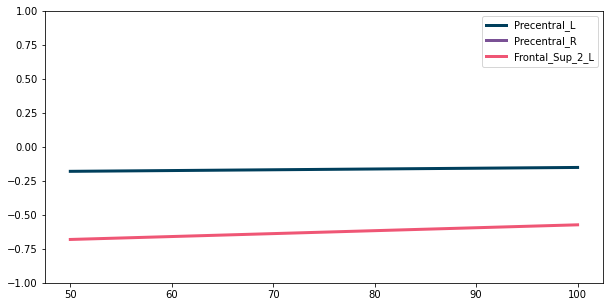

In [8]:
plot_average(modelasymp)

In [23]:
def plot_average(model):
    # —— Get the average individual parameters
    mean_xi = model.model.parameters['xi_mean'].numpy()
    mean_tau = model.model.parameters['tau_mean'].numpy()
    mean_source = model.model.parameters['sources_mean'].numpy().tolist()
    number_of_sources = n_s=model.model.random_variable_informations()["sources"]["shape"][0]
    mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
    average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

    ip_average = IndividualParameters()
    ip_average.add_individual_parameters('average', average_parameters)

    timepoints = np.linspace(50, 100, 100)
    values = model.estimate({'average': timepoints}, ip_average)
    def plot_trajectory_2(timepoints, reconstruction, observations=None):

        if observations is not None:
            ages = observations.index.values
    
        plt.figure(figsize=(10, 5))
        plt.ylim(0, 1)
        colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
        for c, name, val in zip(colors, model.model.features, reconstruction.T):
            plt.plot(timepoints, val, label=name, c=c, linewidth=3)
            if observations is not None:
                plt.plot(ages, observations[name], c=c, marker='o', markersize=12)
        
        
        plt.legend()
        plt.show()
    plot_trajectory_2(timepoints, values['average'])

In [5]:
modelasymp=Leaspy("logistic_asymp")
modelasymp.model.load_hyperparameters({'source_dimension': 1}) 

In [6]:
os.chdir("/Users/samuel.gruffaz/Documents/leaspy")
modelasymp.fit(data1,algo_settings)

3.8694, -3.5152, -3.5340, -5.0680,
        -5.4331, -4.8620, -5.1038, -4.9872, -4.9582, -4.9113])
betas : tensor([[-0.3026],
        [-0.2913],
        [-0.3350],
        [-0.3412],
        [-0.2858],
        [-0.3742],
        [-0.3362]])
tau_mean : 73.03499603271484
tau_std : 15.5708589553833
xi_mean : 0.0
xi_std : 0.9906401038169861
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.0217, 0.0209, 0.0203, 0.0145, 0.0293, 0.0260, 0.0357])

Duration since last print : 15.6982s
|###################-------------------------------|   1140/3000 iterations
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 1200
=Samplers 
    g rate : 29.14%, std: 0.04356
    Param rate : 30.29%, std: 0.01600
    tau rate : 46.06%, std: 6.48487
    xi rate : 26.40%, std: 1.23795
    sources rate : 31.05%, std: 0.36322
    betas rate : 29.14%, std: 0.01299

=== MODEL ===
g : tensor([-1.9169, -1.9986, -2.5288, -2.4121, -2.5102, -2.0593, -1.8572])
Param : tensor([-3.4199, -3.6718, -3.5362, -3.

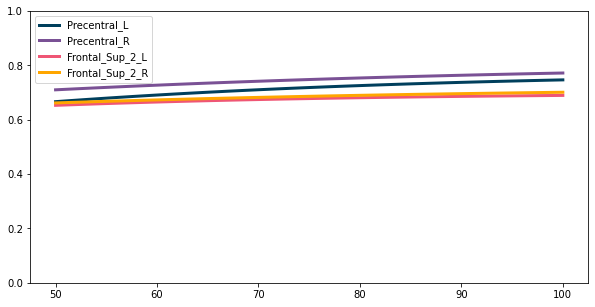

In [11]:
plot_average(modelasymp)

In [26]:
modellogistic=Leaspy("logistic")
modellogistic.model.load_hyperparameters({'source_dimension': 1})

In [27]:
modellogistic.fit(data1,algo_settings)

int : 6.8483s
|######--------------------------------------------|   360/3000 iterations
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 400
=Samplers 
    g rate : 36.00%, std: 0.01369
    v0 rate : 52.00%, std: 0.02095
    tau rate : 94.32%, std: 0.45945
    xi rate : 78.47%, std: 0.44581
    sources rate : 45.47%, std: 0.42957
    betas rate : 14.00%, std: 0.00425

=== MODEL ===
g : tensor([-0.3765, -0.5922, -0.0931])
v0 : tensor([-7.1787, -7.4117, -5.9328])
betas : tensor([[-0.0690],
        [-0.0655]])
tau_mean : 75.01728057861328
tau_std : 5.073500156402588
xi_mean : 0.0
xi_std : 1.6557122468948364
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.0378, 0.0252, 0.0696])

Duration since last print : 6.7567s
|########------------------------------------------|   480/3000 iterations
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 500
=Samplers 
    g rate : 21.33%, std: 0.01280
    v0 rate : 70.67%, std: 0.02881
    tau rate : 92.69%, std: 0.67241
  

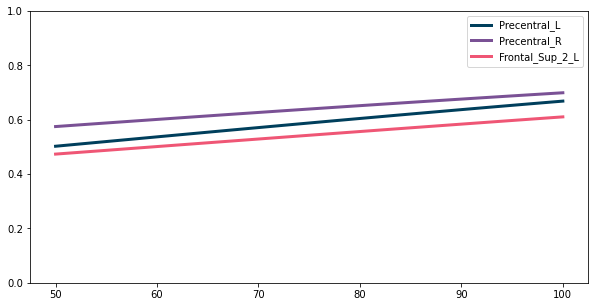

In [30]:
plot_average(modellogistic)

In [28]:
dg=(1-df[df.columns[3:6]])



# —— Store the data into a Data object
data1 = Data.from_dataframe(dg)

In [31]:
modellinear=Leaspy("logistic_asymp")
modellinear.model.load_hyperparameters({'source_dimension': 1})


In [32]:
modellinear.fit(data1,algo_settings)

i_mean : 0.0
xi_std : 1.3247689008712769
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.0255, 0.0190, 0.0315])

Duration since last print : 8.8125s
|#########-----------------------------------------|   540/3000 iterations
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 600
=Samplers 
    g rate : 40.00%, std: 0.03087
    Param rate : 48.67%, std: 0.01422
    tau rate : 87.10%, std: 0.97918
    xi rate : 60.46%, std: 0.89056
    sources rate : 35.89%, std: 0.45747
    betas rate : 44.00%, std: 0.01064

=== MODEL ===
g : tensor([-2.5708, -2.6186, -3.4939])
Param : tensor([-3.5080, -3.6947, -3.7395, -4.9779, -5.3151, -4.9220])
betas : tensor([[-0.4254],
        [-0.3458],
        [-0.3178]])
tau_mean : 75.75702667236328
tau_std : 6.0616607666015625
xi_mean : 0.0
xi_std : 1.5602165460586548
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.0252, 0.0191, 0.0266])

Duration since last print : 8.6070s
|###########---------------------------------------|   660

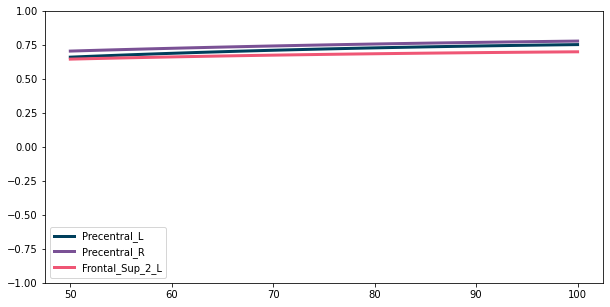

In [33]:
plot_average(modellinear)

In [18]:
dg=(1-df[df.columns[43:49]])
data1 = Data.from_dataframe(dg)


In [19]:
modelinteressant=Leaspy("logistic_asymp")
modelinteressant.model.load_hyperparameters({'source_dimension': 1})

In [20]:
modelinteressant.fit(data1,algo_settings)

    tau rate : 63.04%, std: 3.84381
    xi rate : 30.77%, std: 2.05625
    sources rate : 31.49%, std: 0.25156
    betas rate : 33.33%, std: 0.01995

=== MODEL ===
g : tensor([-3.6885, -3.9365, -2.6267, -1.0122, -0.2483, -0.4087])
Param : tensor([-3.4315, -3.3235, -3.4662, -4.0711, -4.2340, -4.2255, -4.0179, -4.1133,
        -4.3329, -4.9603, -5.3178, -5.1747])
betas : tensor([[0.4034],
        [0.3800],
        [0.3578],
        [0.5753],
        [0.8266],
        [0.7660]])
tau_mean : 74.77587890625
tau_std : 14.565699577331543
xi_mean : 0.0
xi_std : 2.1534008979797363
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.0379, 0.0294, 0.0311, 0.0275, 0.0309, 0.0300])

Duration since last print : 21.6861s
|##################--------------------------------|   1080/3000 iterations
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 1100
=Samplers 
    g rate : 24.00%, std: 0.08782
    Param rate : 33.00%, std: 0.02295
    tau rate : 54.04%, std: 5.11512
    xi rate : 26.2

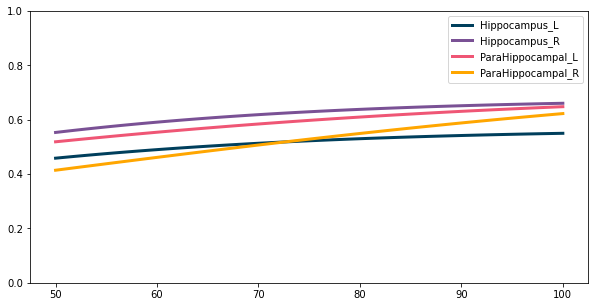

In [24]:
plot_average(modelinteressant)